In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import warnings
warnings.filterwarnings("ignore")

import acgan
import acgan.model.gmm_gan
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import twodlearn as tdl
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import reduce
import matplotlib.pyplot as plt
import datetime
BATCH_SIZE = 16
#acgan.data.DATA_DIR = '/data/marinodl/tensorflow_datasets'


W0829 17:56:27.851288 140110477965120 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
session = tf.InteractiveSession()


In [3]:
print(datetime.datetime.now())

2019-08-29 17:56:55.420656


In [4]:
dataset = acgan.data.load_celeb_a_128_cropped(BATCH_SIZE)
#dataset = acgan.data.load_mnist32(BATCH_SIZE)
input_shape = dataset.output_shapes.as_list()
print('input shape: {}'.format(input_shape))

W0829 17:56:58.118222 140110477965120 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.
W0829 17:56:58.620048 140110477965120 deprecation_wrapper.py:119] From /home/marinodl/research/2019/AssociativeGAN/acgan/data.py:62: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.

W0829 17:56:58.634291 140110477965120 deprecation.py:323] From <ipython-input-4-524ddf9f5df4>:3: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


input shape: [None, 128, 128, 3]


In [ ]:
import twodlearn.debug
@tdl.debug.stop_at_error
def _test():
    model = acgan.model.gmm_gan.GmmGan(
        embedding_size=512,
        generator={'init_shape':(4, 4, 512),
                   'units': [512, 512, 512, 256, 128],
                   'outputs': 3,
                   'kernels': 3,
                   'strides': 2},
        discriminator={'units':[256, 512, 512, 512, 512], #1024
                       'kernels':3,
                       'strides':2,
                       'dropout':None}
    )
    return model
model = _test()
#model.noise_rate.init(rate=0.001)
print('output shape: {}'.format(
    model.generator.compute_output_shape(
        input_shape=[None, 100])))

In [85]:
import collections

@tdl.core.create_init_docstring
class GMM(tdl.core.layers.Layer):
    n_dims = tdl.core.InputArgument.required(
        'n_dims', doc='dimensions of the GMM model')
    n_components = tdl.core.InputArgument.required(
         'n_components', doc='number of mixture components')
    
    @tdl.core.SubmodelInit(lazzy=True)
    def components(self, 
                   init_loc=1e-5, init_scale=1.0,
                   trainable=True, tolerance=1e-5):
        tdl.core.assert_initialized(
            self, 'components', ['n_components', 'n_dims'])
        components = [
            tdl.core.SimpleNamespace(
              loc=tf.Variable(
                  tf.truncated_normal(shape=[self.n_dims], mean=init_loc), 
                  trainable=trainable),
              scale=tdl.constrained.PositiveVariable(
                  init_scale*tf.ones([self.n_dims]),
                  tolerance=tolerance, 
                  trainable=trainable))
            for k in range(self.n_components)]
        return components
    
    @tdl.core.SubmodelInit(lazzy=True)
    def logits(self, trainable=True, tolerance=1e-5):
        tdl.core.assert_initialized(self, 'logits', ['n_components'])
        return tf.Variable(tf.zeros(self.n_components),
                           trainable=trainable)
        
    @tdl.core.SubmodelInit
    def dist(self, mix=None):
        tdl.core.assert_initialized(self, 'dist', ['components', 'logits'])
        bimix_gauss = tfp.distributions.Mixture(
            cat=tfp.distributions.Categorical(logits=self.logits),
            components=[
                tfp.distributions.MultivariateNormalDiag(
                    loc=comp.loc, scale_diag=tf.convert_to_tensor(comp.scale))
                for comp in self.components])
        return bimix_gauss
    
    def log_prob(self, inputs):
        return self.dist.log_prob(inputs)
        
    def call(self, inputs=None):
        return self.dist.sample(inputs)
    
    

In [86]:
#a = GMM(n_dims=1)
model = GMM(
    n_components=5, n_dims=2, 
    components={'init_loc':0.01, 'init_scale':0.1,
                'tolerance':1e-5}).build()
tdl.core.initialize_variables(model)

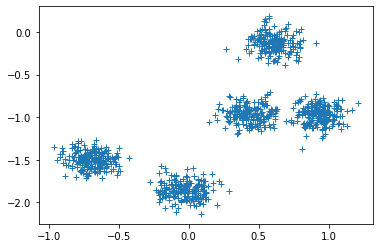

In [92]:
import matplotlib.pyplot as plt

#x = model.dist.sample(100).eval()
x = model(1000).eval()
plt.plot(x[:, 0], x[:, 1], '+')